## Imports

In [ ]:
# !pip3 install openai==0.27.0 --quiet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import openai
from google.colab import userdata

import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re
import time
import json
import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/drive


In [ ]:
DATA_PATH = ""

FA = "4"
PROMPT_PATH = ""
RESULTS_PATH = ""

SEED = 312
N_BOOTSTRAP = 5000

In [ ]:
JUDGE_MODEL = "o3-2025-04-16"
openai.api_key = userdata.get("")

model_ids = [model.id for model in openai.Model.list().data]
assert JUDGE_MODEL in model_ids

## Data

In [ ]:
df = pd.read_csv(DATA_PATH)
df = df[df["Role"]=="assistant"]
df = df[df["Assessment ID"]==int(FA)]
df = df.rename(columns={'XYZ ID':'student','Assessment ID':'assessment',\
                        'Conversation No.': 'turn','Role':'role','Response':'utterance'})
df = df.drop(columns=["Version"])
df = df.reset_index(drop=True)

assert not df.isnull().values.any()

assert df['student'].dtype == 'object'
assert df['student'].apply(lambda x: bool(re.fullmatch(r'XYZ25\d{3}', str(x)))).all()
assert df['assessment'].dtype == int
assert set(df['assessment'].unique()) == {int(FA)}
assert df['turn'].dtype == int
assert all(df['turn'] % 2)
assert df['role'].dtype == 'object'
assert set(df['role'])=={'assistant'}
assert df['utterance'].dtype == 'object'

df.head()

## Prompt

In [ ]:
with open(PROMPT_PATH, 'r', encoding='utf-8') as f:
    prompt = f.read()

prompt

'You are a learning science researcher whose job it is to determine if a pedagogical agent\'s feedback to students promotes self-efficacy in the student, as defined by Bandura, by identifying the degree to which the agent\'s most recent utterance helps the student believe in their ability to succeed and overcome challenges.\n\nYou are to evaluate the agent\'s ability to promote self-efficacy using the following decision tree (which uses Python syntax with capitalized conditional keywords):\nIF the agent provides explicit words of praise or encouragement to the student: # i.e., the agent explicitly praises the student for doing a good job (e.g.,"Great work", "Nice job", "Keep it up", etc.)  or encourages a student when they struggle  (e.g.,"You got this", "You\'ll get it in no time", "You\'re almost there")\n    self_efficacy = 1\nELIF the agent does not explicitly provide words of praise or encouragement but conveys a generally upbeat and positive attitude (e.g., by using punctuation l

## API Call

In [ ]:
def get_openai_response(messages):
  start_time = time.time()
  response = openai.ChatCompletion.create(
      model=JUDGE_MODEL,
      messages=messages,
      response_format={ "type": "json_object" },
      seed=SEED)
  total_time = time.time()-start_time
  total_tokens = response["usage"]["total_tokens"]
  generation = response["choices"][0]["message"]["content"].strip()

  return generation, total_time, total_tokens

In [ ]:
response = get_openai_response([{"role":"system","content":"Confirm that the api is working. Respond using the following JSON schema: {'working':bool, 'explanation':str}"}])
print(response)

('{"working": true, "explanation": "The API responded successfully and is functioning as expected."}', 3.7464637756347656, 198)


## Generations

In [ ]:
results = [["messages","generation","total_time_s","total_tokens","explanation","self_efficacy_score"]]

for idx,row in df.iterrows():
    agent_str = "Agent: "+row['utterance']
    messages = [{"role":"system","content":prompt},{"role":"user","content":agent_str}]

    generation, total_time, total_tokens = get_openai_response(messages)
    parsed_generation = json.loads(generation)

    explanation = parsed_generation["explanation"]
    self_efficacy_score = parsed_generation["self_efficacy_score"]

    results.append([messages,generation,total_time,total_tokens,explanation,self_efficacy_score])

    print(f"FINISHED UTTERANCE {idx}, TURN {row.turn}.")

FINISHED UTTERANCE 0, TURN 1.
FINISHED UTTERANCE 1, TURN 3.
FINISHED UTTERANCE 2, TURN 5.
FINISHED UTTERANCE 3, TURN 7.
FINISHED UTTERANCE 4, TURN 9.
FINISHED UTTERANCE 5, TURN 11.
FINISHED UTTERANCE 6, TURN 1.
FINISHED UTTERANCE 7, TURN 3.
FINISHED UTTERANCE 8, TURN 5.
FINISHED UTTERANCE 9, TURN 7.
FINISHED UTTERANCE 10, TURN 9.
FINISHED UTTERANCE 11, TURN 1.
FINISHED UTTERANCE 12, TURN 3.
FINISHED UTTERANCE 13, TURN 5.
FINISHED UTTERANCE 14, TURN 7.
FINISHED UTTERANCE 15, TURN 9.
FINISHED UTTERANCE 16, TURN 11.
FINISHED UTTERANCE 17, TURN 13.
FINISHED UTTERANCE 18, TURN 15.
FINISHED UTTERANCE 19, TURN 17.
FINISHED UTTERANCE 20, TURN 19.
FINISHED UTTERANCE 21, TURN 21.
FINISHED UTTERANCE 22, TURN 23.
FINISHED UTTERANCE 23, TURN 25.
FINISHED UTTERANCE 24, TURN 27.
FINISHED UTTERANCE 25, TURN 29.
FINISHED UTTERANCE 26, TURN 31.
FINISHED UTTERANCE 27, TURN 33.
FINISHED UTTERANCE 28, TURN 35.
FINISHED UTTERANCE 29, TURN 37.
FINISHED UTTERANCE 30, TURN 39.
FINISHED UTTERANCE 31, TURN 41.
F

## Save

In [ ]:
df_results = pd.DataFrame(results[1:], columns=results[0])
df = pd.concat([df, df_results], axis=1)
df.to_csv(RESULTS_PATH, index=False)

## EDA

In [ ]:
df_results = pd.read_csv(RESULTS_PATH)
df_results = df_results[df_results["assessment"]==int(FA)]
df_results.head()

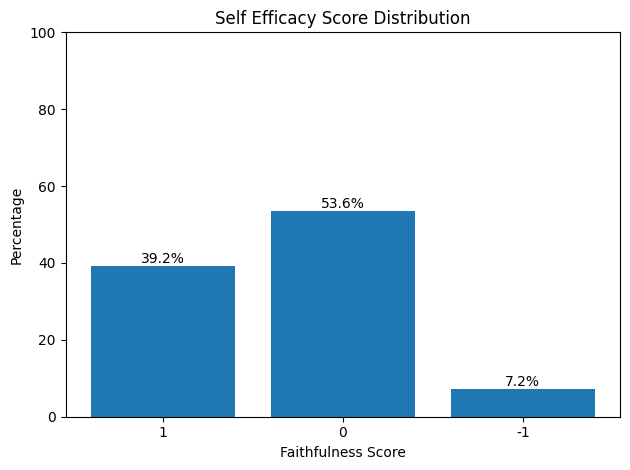

In [4]:
col = "self_efficacy_score"

pct = (
  df_results[col]
  .value_counts(normalize=True)
  .reindex([1, 0, -1], fill_value=0)
  .mul(100)
)

plt.figure()
bars = plt.bar(pct.index.astype(str), pct.values)
plt.title(f"{col.replace('_', ' ').title()} Distribution")
plt.xlabel("Faithfulness Score")
plt.ylabel("Percentage")

for bar, value in zip(bars, pct.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.1f}%",
        ha="center",
        va="bottom",
    )

plt.ylim(0, 100)
plt.tight_layout()

## Confidence Intervals

In [5]:
boot_self_efficacy_yes  = []
boot_self_efficacy_no = []

values = df_results["self_efficacy_score"].to_numpy()

rng = np.random.default_rng(seed=SEED)

for _ in range(N_BOOTSTRAP):
    resample = rng.choice(values, size=len(df_results), replace=True)
    boot_self_efficacy_yes.append((resample ==  1).mean())
    boot_self_efficacy_no.append((resample == -1).mean())

self_efficacy_yes_low,  self_efficacy_yes_high  = np.percentile(boot_self_efficacy_yes,[2.5, 97.5])
self_efficacy_no_low, self_efficacy_no_high = np.percentile(boot_self_efficacy_no,[2.5, 97.5])

win_moe  = (self_efficacy_yes_high-self_efficacy_yes_low) / 2
loss_moe = (self_efficacy_no_high-self_efficacy_no_low) / 2

p_cons   = (values ==  1).mean()
p_incons = (values == -1).mean()

print(f"Self-efficacy yes (1): {p_cons*100:.2f} ± {win_moe*100:.2f}  (95 % CI)")
print(f"Self-efficacy no (-1): {p_incons*100:.2f} ± {loss_moe*100:.2f}  (95 % CI)")

Self-efficacy yes (1): 39.22 ± 3.06  (95 % CI)
Self-efficacy no (-1): 7.22 ± 1.60  (95 % CI)
